In [16]:
import pandas as pd
import numpy as np

In [17]:
df=pd.read_csv('./TECHM.csv')
df.set_index('Date',inplace=True)
df.dropna(inplace=True)
data=df.copy()


In [18]:
lag_features=['High','Low','Volume','Turnover','Trades']
window1=3
window2=7
for feature in lag_features:
    data[feature+'rolling_mean_3']=data[feature].rolling(window=window1).mean()
    data[feature+'rolling_mean_7']=data[feature].rolling(window=window2).mean()

for feature in lag_features:
    data[feature+'rolling_std_3']=data[feature].rolling(window=window1).std()
    data[feature+'rolling_std_7']=data[feature].rolling(window=window2).std()

data.dropna(inplace=True)
# vwap => volume weighted average price

In [19]:
from pmdarima import auto_arima

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
training_data=data[0:1800]
test_data=data[1800:]

In [22]:
ind_features=['Highrolling_mean_3', 'Highrolling_mean_7',
       'Lowrolling_mean_3', 'Lowrolling_mean_7', 'Volumerolling_mean_3',
       'Volumerolling_mean_7', 'Turnoverrolling_mean_3',
       'Turnoverrolling_mean_7', 'Tradesrolling_mean_3',
       'Tradesrolling_mean_7', 'Highrolling_std_3', 'Highrolling_std_7',
       'Lowrolling_std_3', 'Lowrolling_std_7', 'Volumerolling_std_3',
       'Volumerolling_std_7', 'Turnoverrolling_std_3', 'Turnoverrolling_std_7',
       'Tradesrolling_std_3', 'Tradesrolling_std_7']

In [23]:
model=auto_arima(y=training_data['VWAP'],exogenous=training_data[ind_features],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19412.620, Time=1.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19410.737, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19409.537, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19409.474, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19408.738, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19411.413, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.198 seconds


In [24]:
model.fit(training_data['VWAP'],training_data[ind_features])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
forecast=model.predict(n_periods=len(test_data), X=test_data[ind_features])
forecast


1800    760.216520
1801    758.351530
1802    756.704956
1803    742.823731
1804    746.912262
           ...    
2445    932.703024
2446    958.336016
2447    955.475347
2448    961.715555
2449    947.883265
Length: 650, dtype: float64

In [26]:
forecast_df = pd.DataFrame(forecast, columns=['Forecast_ARIMA'])
forecast_df['Date'] = test_data.index
forecast_df = forecast_df.set_index('Date')
merged_df = pd.merge(test_data, forecast_df, 'outer', on='Date' )

In [27]:
forecast_df
merged_df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,Highrolling_std_7,Lowrolling_std_3,Lowrolling_std_7,Volumerolling_std_3,Volumerolling_std_7,Turnoverrolling_std_3,Turnoverrolling_std_7,Tradesrolling_std_3,Tradesrolling_std_7,Forecast_ARIMA
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-11,TECHM,EQ,766.25,772.00,773.80,738.45,746.00,747.20,753.58,3817364,...,4.365871,13.551783,9.606310,8.816581e+05,1.276951e+06,6.464303e+13,9.797688e+13,35848.684081,41214.549420,760.216520
2018-09-12,TECHM,EQ,747.20,750.00,751.90,728.60,741.10,739.80,742.32,3934021,...,9.843895,15.319187,12.689356,6.121470e+05,1.273171e+06,4.268999e+13,9.767307e+13,20114.242972,40269.237559,758.351530
2018-09-14,TECHM,EQ,739.80,739.90,761.80,721.55,759.00,760.45,745.63,3591403,...,10.448861,8.488571,16.729262,1.741907e+05,1.247181e+06,1.292349e+13,9.585247e+13,18552.622708,40372.796591,756.704956
2018-09-17,TECHM,EQ,760.45,759.50,772.75,755.00,767.60,767.55,766.95,2233000,...,9.873564,17.633136,16.506665,8.996405e+05,8.231665e+05,6.388936e+13,6.038127e+13,27909.283157,28812.742487,742.823731
2018-09-18,TECHM,EQ,767.55,769.85,769.85,750.00,761.00,754.70,756.05,2206998,...,8.903123,18.043027,16.028241,7.918872e+05,8.173397e+05,5.704272e+13,5.912176e+13,10257.384023,28371.541221,746.912262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,TECHM,EQ,950.20,951.00,970.00,937.00,970.00,962.20,949.75,5053998,...,18.988308,11.989197,20.670024,6.659120e+05,9.765859e+05,6.508813e+13,9.017188e+13,23496.112026,22174.196031,932.703024
2021-04-27,TECHM,EQ,962.20,962.70,987.60,944.15,968.80,969.25,962.64,10497935,...,18.229754,4.532200,22.190946,3.517702e+06,2.665513e+06,3.407931e+14,2.534114e+14,71013.764668,50729.778257,958.336016
2021-04-28,TECHM,EQ,969.25,975.00,980.00,968.00,977.90,977.40,974.22,2968625,...,15.914769,16.232401,17.172791,3.887496e+06,2.625415e+06,3.737829e+14,2.506302e+14,72583.373002,47922.654739,955.475347


In [28]:
import pickle

In [29]:
with open('TechM.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(forecast_df, file)

In [30]:
import matplotlib.pyplot as plt


In [31]:
# date=forecast_df['Date']
values=forecast_df['Forecast_ARIMA']

In [32]:
forecast_df

,Forecast_ARIMA
Date,
2018-09-11,760.216520
2018-09-12,758.351530
2018-09-14,756.704956
2018-09-17,742.823731
2018-09-18,746.912262
...,...
2021-04-26,932.703024
2021-04-27,958.336016
2021-04-28,955.475347


<AxesSubplot:xlabel='Date'>

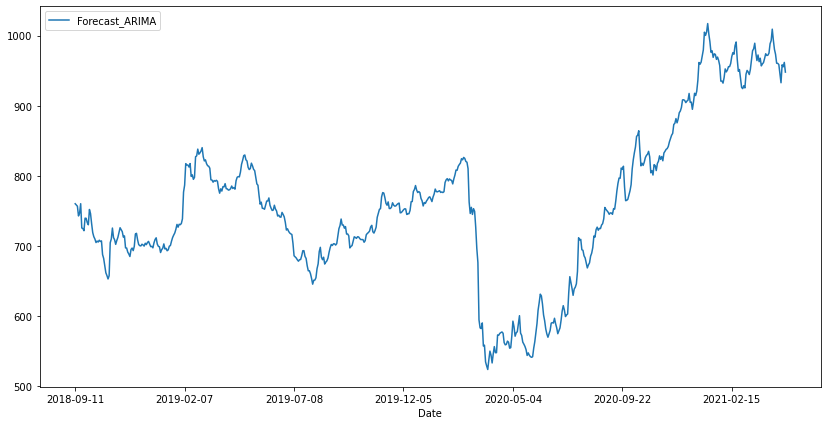

In [33]:
forecast_df[['Forecast_ARIMA']].plot(figsize=(14,7))